# A/B Testing


## Web page
Testing to see effects on user purchase conversion by splitting users into 2 groups.

1. Control: Original Webpage
2. Treatment: New webpage

**Conversion:** A user makes a purchase within 7 days after their first exposure to the webpage. 

In [ ]:
import numpy as np
import pandas as pd 

In [2]:
df = pd.read_csv("/kaggle/input/abtestdata/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [18]:
df.shape

(294478, 5)

In [5]:
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal

In [15]:
import datetime

In [17]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Total number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in treatment: {round(df[df['group']=='treatment'].shape[0] * 100 / df.shape[0])}%")

Total number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in treatment: 50%


In [42]:
df_control = df.group == 'control'
df_control = df[df_control]
df_treatment = df.group != 'control'
df_treatment = df[df_treatment]

In [43]:
df_control.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [44]:
df_treatment.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [60]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [79]:
df['week'] = df['timestamp'].dt.week

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


### Levene's Test

- **H0: Variances are homogeneous**
- **H1: Varainces are not Homogenous**

Levene's test is an inferential statistic used to assess the equality of variances for a variable calculated for two or more groups

In [47]:
_, pvalue = levene(df_control['converted'], df_treatment.converted)
print("P-value:", pvalue)

P-value: 0.21611748563652222


Since the p-value > 0.05 cannot reject the null hypothesis so there is **homogenous variance distribution**

### Frequency Approach

Determing the conversion rates for both control and treatment groups

In [77]:
control_conv = round(df_control.converted.sum() / df_control.converted.count() * 100,3)
treatment_conv = round(df_treatment.converted.sum() / df_treatment.converted.count() * 100,3)


print(f"Control Conversion Rate: {control_conv}%")
print(f"Treatment Conversion Rate: {treatment_conv}%")

Control Conversion Rate: 12.04%
Treatment Conversion Rate: 11.892%


### A/B Hypothesis Test function

In [52]:
def hypothesisTest(df_A, df_B, col_name):
    
    test_stat_A, pvalue_A = shapiro(df_A[col_name])
    test_stat_B, pvalue_B = shapiro(df_B[col_name])
    test_stat_var, pvalue_var = levene(df_A[col_name], df_B[col_name])
    
    print('*Normalization Check:')
    print('Shapiro Test for Control Group, Stat = %.4f, p-value = %.4f' % (test_stat_A, pvalue_A))
    print('Shapiro Test for Test Group, Stat = %.4f, p-value = %.4f' % (test_stat_B, pvalue_B))
    
    print('*Variance Check:')
    print('Levene Test Stat = %.4f, p-value = %.4f' % (test_stat_var, pvalue_var))
    
    if pvalue_A < 0.05 and pvalue_B < 0.05:
        test_stat, pvalue = mannwhitneyu(df_A[col_name], df_B[col_name])

        print("\n")
        print('Mann–Whitney U Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
        print(f'H0 hypothesis {"NOT REJECTED" if pvalue > 0.05 else "REJECTED"} in Mann–Whitney U Test')
        
    else:
        test_stat, pvalue = ttest_ind(df_A[col_name], df_B[col_name], equal_var=(True if pvalue_var > 0.05 else False))

        print("\n")
        print('Independent Samples T Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
        print(f'H0 hypothesis {"NOT REJECTED" if pvalue > 0.05 else "REJECTED"}, Independent Samples T Test')

In [53]:
hypothesisTest(df_control, df_treatment, 'converted');

*Normalization Check:
Shapiro Test for Control Group, Stat = 0.3796, p-value = 0.0000
Shapiro Test for Test Group, Stat = 0.3770, p-value = 0.0000
*Variance Check:
Levene Test Stat = 1.5300, p-value = 0.2161


Mann–Whitney U Test Stat = 10855699236.0000, p-value = 0.2161
H0 hypothesis NOT REJECTED in Mann–Whitney U Test


The treatment group has lower conversion rates so no change should be made.

## Mobile App/Game A/B Testing

Cookie Cats is a popular mobile puzzle game

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

In [80]:
mdf = pd.read_csv("/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv")
mdf.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


**Summary stats about the dataset:**

In [84]:
mdf.shape

(90189, 5)

In [85]:
mdf.info

<bound method DataFrame.info of         userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]>

In [86]:
mdf.describe

<bound method NDFrame.describe of         userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]>

In [87]:
print("Number of unique users:", mdf.userid.nunique())

Number of unique users: 90189


In [88]:
mdf.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


In [89]:
import matplotlib.pyplot as plt

<AxesSubplot:>

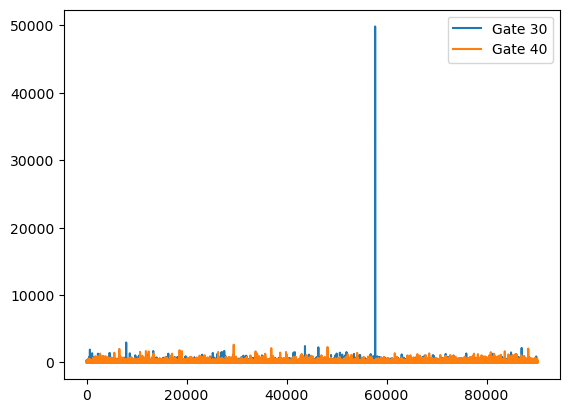

In [90]:
mdf[mdf.version == 'gate_30'].sum_gamerounds.plot(label = 'Gate 30',legend = True)
mdf[mdf.version == 'gate_40'].sum_gamerounds.plot(label = 'Gate 40', legend = True)

**Removing Outliers**

In [91]:
mdf = mdf[mdf.sum_gamerounds < mdf.sum_gamerounds.max()]

<AxesSubplot:>

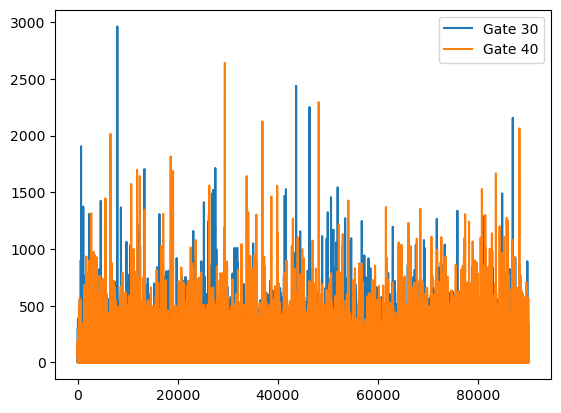

In [92]:
mdf[mdf.version == 'gate_30'].sum_gamerounds.plot(label = 'Gate 30',legend = True)
mdf[mdf.version == 'gate_40'].sum_gamerounds.plot(label = 'Gate 40', legend = True)

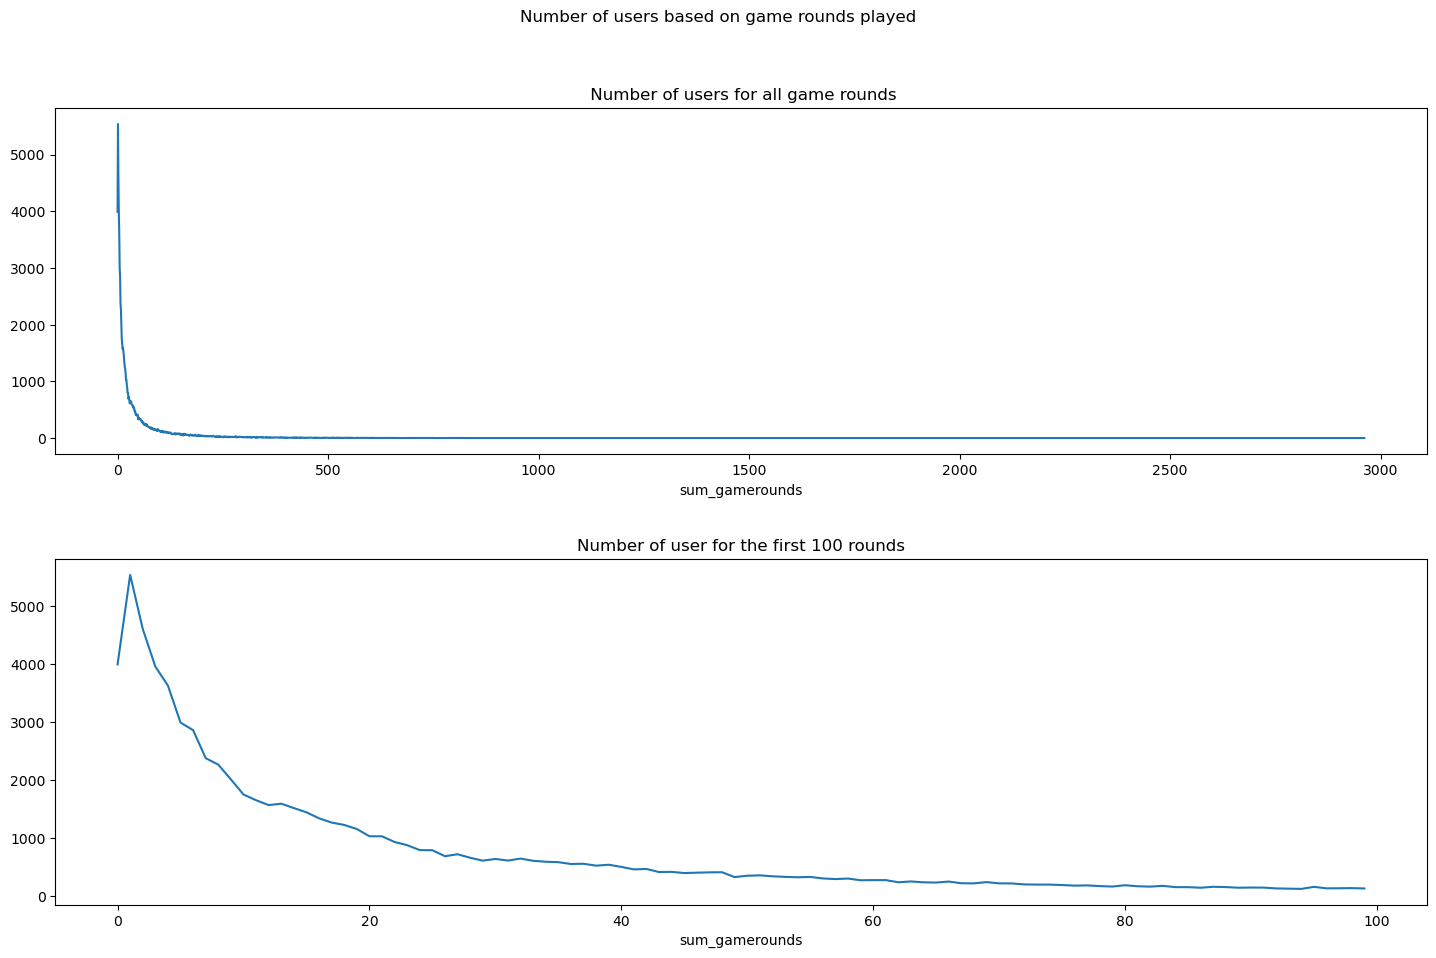

In [97]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))
mdf.groupby("sum_gamerounds").userid.count().plot(ax = ax[0])
mdf.groupby("sum_gamerounds").userid.count()[:100].plot(ax = ax[1])
plt.suptitle("Number of users based on game rounds played")
ax[0].set_title(" Number of users for all game rounds")
ax[1].set_title("Number of user for the first 100 rounds")
plt.tight_layout(pad = 3)

With increasing game rounds there is higher churn with user count dropping to single digits around 400 rounds


This could be due to:
- increased difficulty
- novelty of the game wears off
- There are other games or activities for the player to try
- players have less time to play

In [103]:
mdf.groupby("sum_gamerounds").userid.count().reset_index().sample(20).sort_values(by = 'sum_gamerounds')

,sum_gamerounds,userid
63,63,254
84,84,156
140,140,82
217,217,30
392,392,11
438,438,6
464,464,4
516,516,3
568,569,7
582,583,4


In [140]:
mdf.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


Player retention is given by: 
- `retention_1` True if the player return to play for 1 day after installing
- `retention_7` True if the player continues playing for at least 7 days after installing the game

In [105]:
pd.DataFrame({
    'Retion_1 Count' : mdf['retention_1'].value_counts(),
    'Retion_7 Count' : mdf['retention_7'].value_counts(),
    'Retion_1 percent' : mdf['retention_1'].value_counts() / len(mdf) * 100,
    'Retion_7 percent' : mdf['retention_7'].value_counts() / len(mdf) * 100,
})

,Retion_1 Count,Retion_7 Count,Retion_1 percent,Retion_7 percent
False,50035,73408,55.478556,81.394421
True,40153,16780,44.521444,18.605579


- 55% of the players don't play after day 1.
- 81% of the players don't play up to day 7.

In [107]:
mdf.groupby(["version", "retention_1", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_1 retention_7                                             
gate_30 False       False        22840     6.0   11.819746   21.642643   981
                    True          1825    43.0   73.169315   93.222330  1072
        True        False        13358    33.0   49.694490   58.125396   918
                    True          6676   127.0  183.886309  189.626390  2961
gate_40 False       False        23597     6.0   11.913294   20.901020   547
                    True          1773    47.0   75.261139   94.478048  1241
        True        False        13613    32.0   50.025490   60.924587  2640
                    True          6506   133.0  190.282355  194.220077  2294

In [113]:
mdf['completeRetention'] = np.where((mdf.retention_1 == True) & (mdf.retention_7 == True), 1,0);
mdf.groupby(['version', 'completeRetention']).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count  median        mean         std   max
version completeRetention                                             
gate_30 0                  38023    12.0   28.070273   48.017452  1072
        1                   6676   127.0  183.886309  189.626390  2961
gate_40 0                  38983    12.0   28.103353   48.927850  2640
        1                   6506   133.0  190.282355  194.220077  2294

In [115]:
mdf1 = mdf.copy()
mdf1['version'] = np.where(mdf.version == 'gate_30', "A", "B")
mdf1.head()

,userid,version,sum_gamerounds,retention_1,retention_7,completeRetention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


In [136]:
def ABtest( data, group, Target):
    
    # A/B Split
    groupA = data[data[group] == "A"][Target]
    groupB = data[data[group] == "B"][Target]
    
    # Normality Assumption
    # H0: Distribution is Gaussian -- False
    # H1: Distribution is not Gaussian -- True
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    # if H0: True
    if (ntA == False) and (ntB == False):
        # Variance is Homogenous
        leveneTest = levene(groupA, groupB)[1] < 0.05
        
        if leveneTest is False:
            ttest = ttest_ind(groupA, groupB, equal_var = True)[1]
        else:
            ttest = ttest_ind(groupA, groupB, equal_var = False)[1]
    else:
        # Non-Parametric 
        ttest = mannwhitneyu(groupA, groupB)[1]
    
    # Results
    results = pd.DataFrame({
        "A/B Hypothesis": [ttest < 0.05],
        "p-value" : [ttest]
    })
    results["description"] = np.where(results["A/B Hypothesis"] == False, "A/B group results are similar", "A/B group are not similar")
    results["Test Type"] = np.where( (ntA == False) and (ntB == False), "Parametric", "Non-Parametric" )
    
    
    return results


In [137]:
ABtest(mdf1, "version", "sum_gamerounds")

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,A/B Hypothesis,p-value,description,Test Type
0,False,0.050892,A/B group results are similar,Non-Parametric


In [139]:
mdf1.groupby("version").retention_1.mean(), mdf1.groupby("version").retention_7.mean()

(version
 A    0.448198
 B    0.442283
 Name: retention_1, dtype: float64,
 version
 A    0.190183
 B    0.182000
 Name: retention_7, dtype: float64)

### Conclusion

- There is higher retention when the gate is at level 30 rather than gate 40 however there is minor difference based on the statistical analysis.
- Since there is high player churn as the players progress through the game, fewer players will reach level 40 than level 30 and thus are less likely to make the in-app purchase or the wait time, (each of which can be viewed as a cost incurred by the player indicating investment in the game). Once the player had payed cost via purchase or time they are more likely to continue due to sunk cost so having so the sooner such a transaction occurs more players will take part since the game the game looses players with each advancing levels. 


Level 1 has the highest player count followed with an exponential decay in players with increasing levels so there needs to a be balance between introducing this transaction early in the game but not too early to cause faster churn at earlier levels. 